<a href="https://www.kaggle.com/code/oscarm524/ps3-ep12-eda-modeling?scriptVersionId=124511823" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Description](#4)

[5. Data Exploration](#5)

[6. Baseline Modeling 1.0](#6)
 - [6.1 Logistic Regression](#6.1)   
 - [6.2 Random Forest](#6.2)
 - [6.3 Extra Trees](#6.3)
 - [6.4 GradientBoosting](#6.4)
 - [6.5 HistGradientBoosting](#6.5)
 - [6.6 LightGBM](#6.6)
 - [6.7 XGBoost](#6.7)
 - [6.8 CatBoost](#6.8)
 - [6.9 Model Comparison](#6.9)


<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (03/06/2023)
    * EDA 
    * Data Exploration
    * Baseline modeling 1.0    

<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e12/train.csv')
test = pd.read_csv('../input/playground-series-s3e12/test.csv')
submission = pd.read_csv('../input/playground-series-s3e12/sample_submission.csv')

print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (414, 8)
The dimession of the test dataset is: (276, 7)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [4]:
train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [5]:
train.describe()

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [6]:
test.head()

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00
3,417,1.020,5.33,668,25.3,252,3.46
4,418,1.011,5.87,567,29.0,457,2.36


In [7]:
test.describe()

,id,gravity,ph,osmo,cond,urea,calc
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,551.500000,1.018330,5.939312,654.891304,21.886594,280.985507,4.076848
std,79.818544,0.006569,0.607143,236.361932,7.346069,134.877856,3.088524
min,414.000000,1.005000,4.900000,187.000000,5.100000,64.000000,0.170000
25%,482.750000,1.014000,5.530000,456.000000,17.400000,168.500000,1.527500
50%,551.500000,1.019000,5.730000,658.000000,23.600000,282.000000,3.230000
75%,620.250000,1.023250,6.210000,843.250000,27.600000,385.000000,5.540000
max,689.000000,1.034000,7.940000,1236.000000,38.000000,620.000000,14.340000


> <div class="alert alert-block alert-info">
<b>💡</b> There are no missing values neither in the train nor test datasets. Also, by a quick eye-ball comparison of the summary statistics of the train and test datasets, they seem to have similar distributions. 
</div>

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Description</h1>

This is a synthetic dataset generated from the [Kidney Stone Prediction based on Urine Analysis](https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis) dataset. These are the descriptions of the variables in this dataset:

<ul>
    <li> id: id of the obsevation. </li>
    <li> gravity: specific gravity, the density of the urine relative to water. </li>
    <li> ph: he negative logarithm of the hydrogen ion. </li>
    <li> osmo: osmolarity. Osmolarity is proportional to the concentration of
molecules in solution. </li>
    <li> cond: conductivity (mMho milliMho). One Mho is one
reciprocal Ohm. Conductivity is proportional to the concentration of charged
ions in solution. </li>
    <li> urea: urea concentration in millimoles per litre. </li>
    <li> calc: calcium
concentration (CALC) in millimolesllitre. </li>
    <li> target: 0- absence of stone 1- presence of stone. </li>
</ul>

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1> 

In [8]:
round(100*train['target'].value_counts() / train.shape[0], 2) 

0    55.56
1    44.44
Name: target, dtype: float64

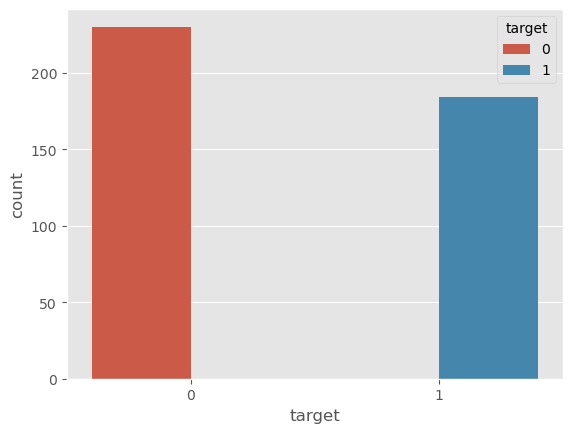

In [9]:
sns.countplot(x = 'target', hue = 'target', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above chart, we see that the data is pretty balanced (56%-44%).</div>

We next proceed to explore the relationship between the input and target variables.

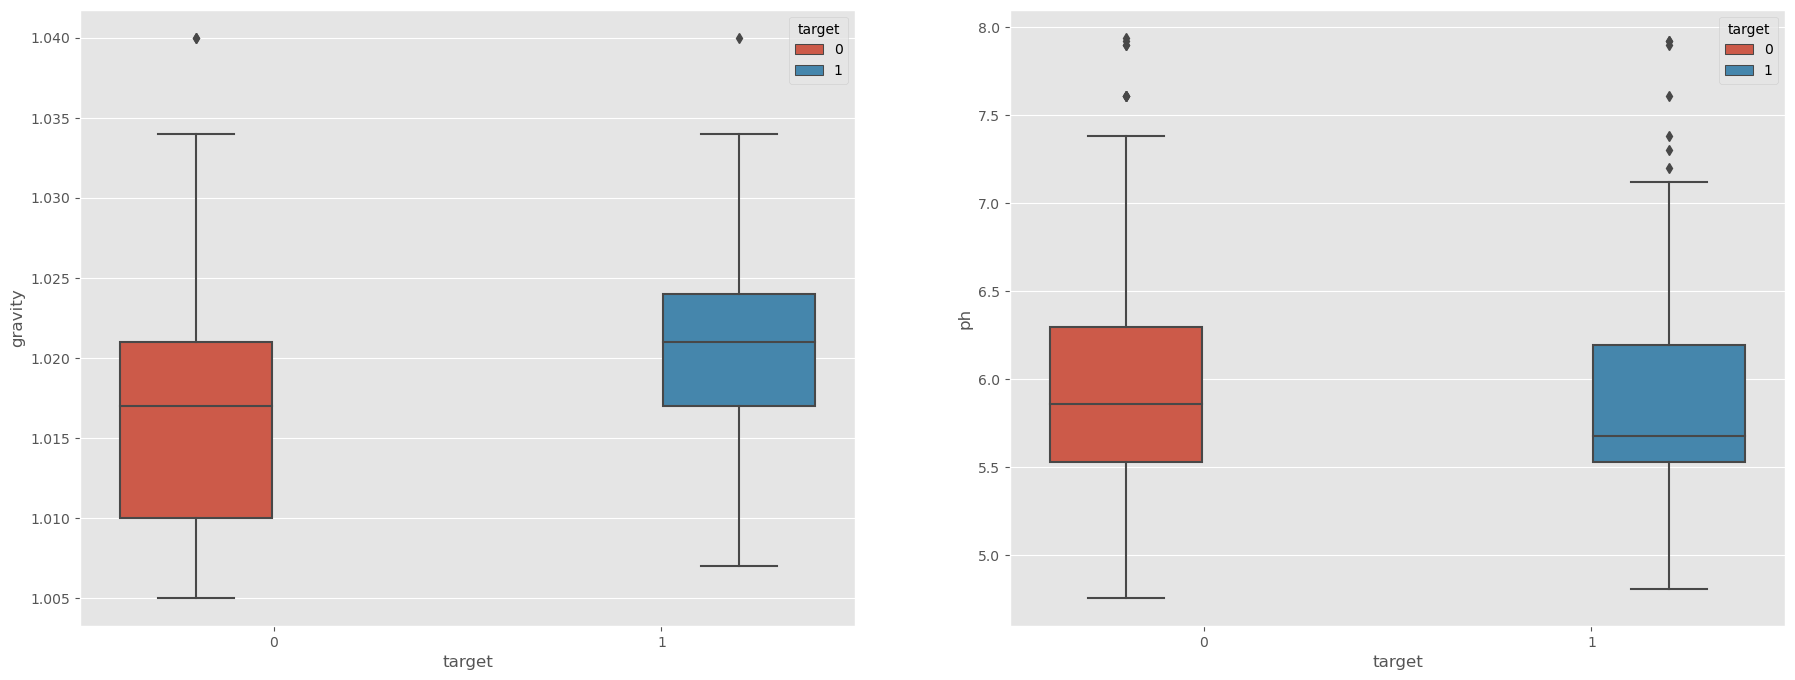

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'target', y = 'gravity', hue = 'target', data = train)
sns.boxplot(ax = axes[1], x = 'target', y = 'ph', hue = 'target', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above boxplots, we see the median of target=1 of gravity is larger than target=0.</div>

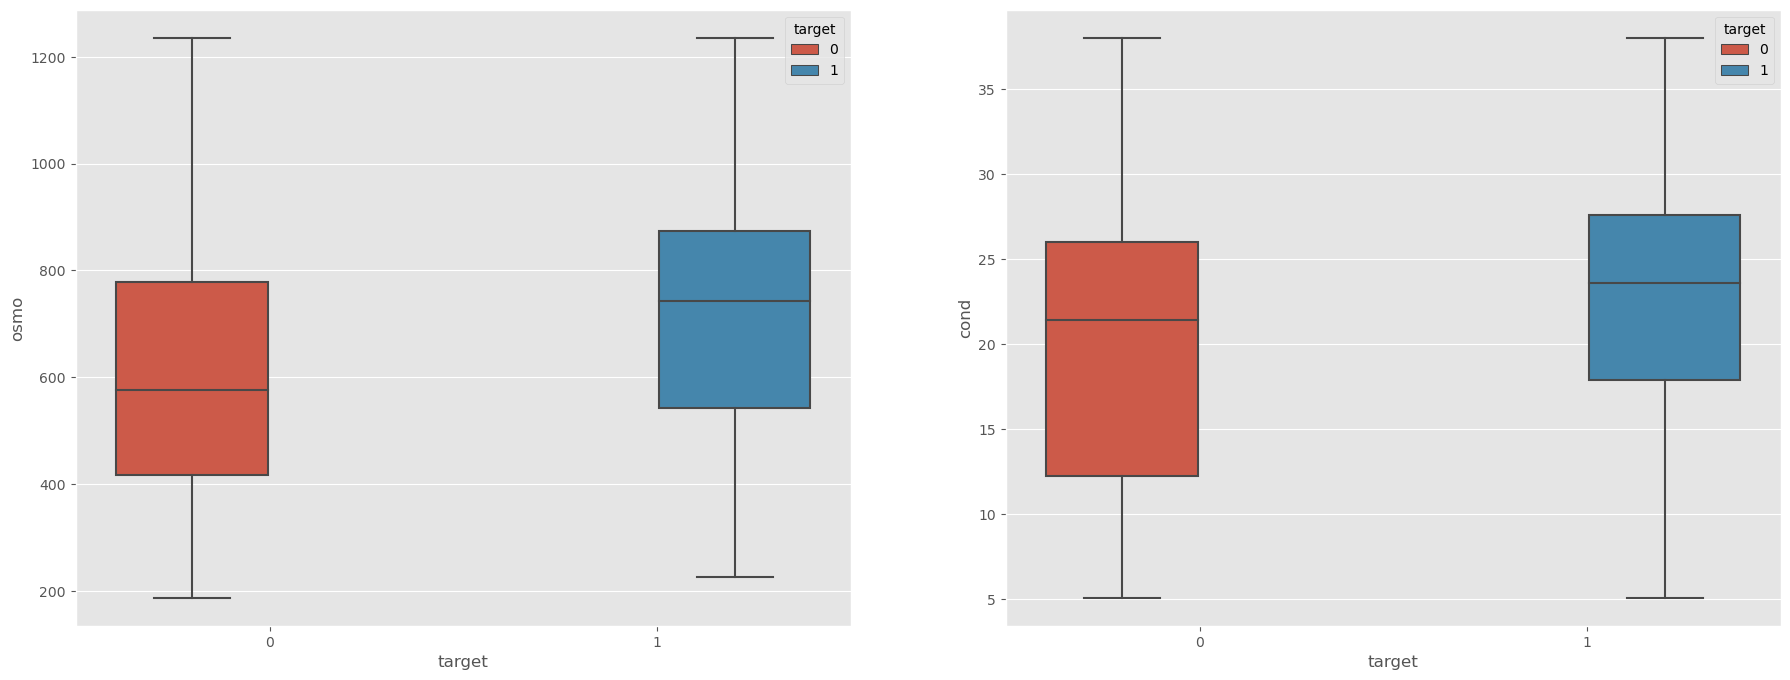

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'target', y = 'osmo', hue = 'target', data = train)
sns.boxplot(ax = axes[1], x = 'target', y = 'cond', hue = 'target', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> In the left panel, we see the median of target=1 of osmo is larger than target=0. On the other hand, in the right panel, we see that the median of target=1 is slighlty larger than target=0 </div>

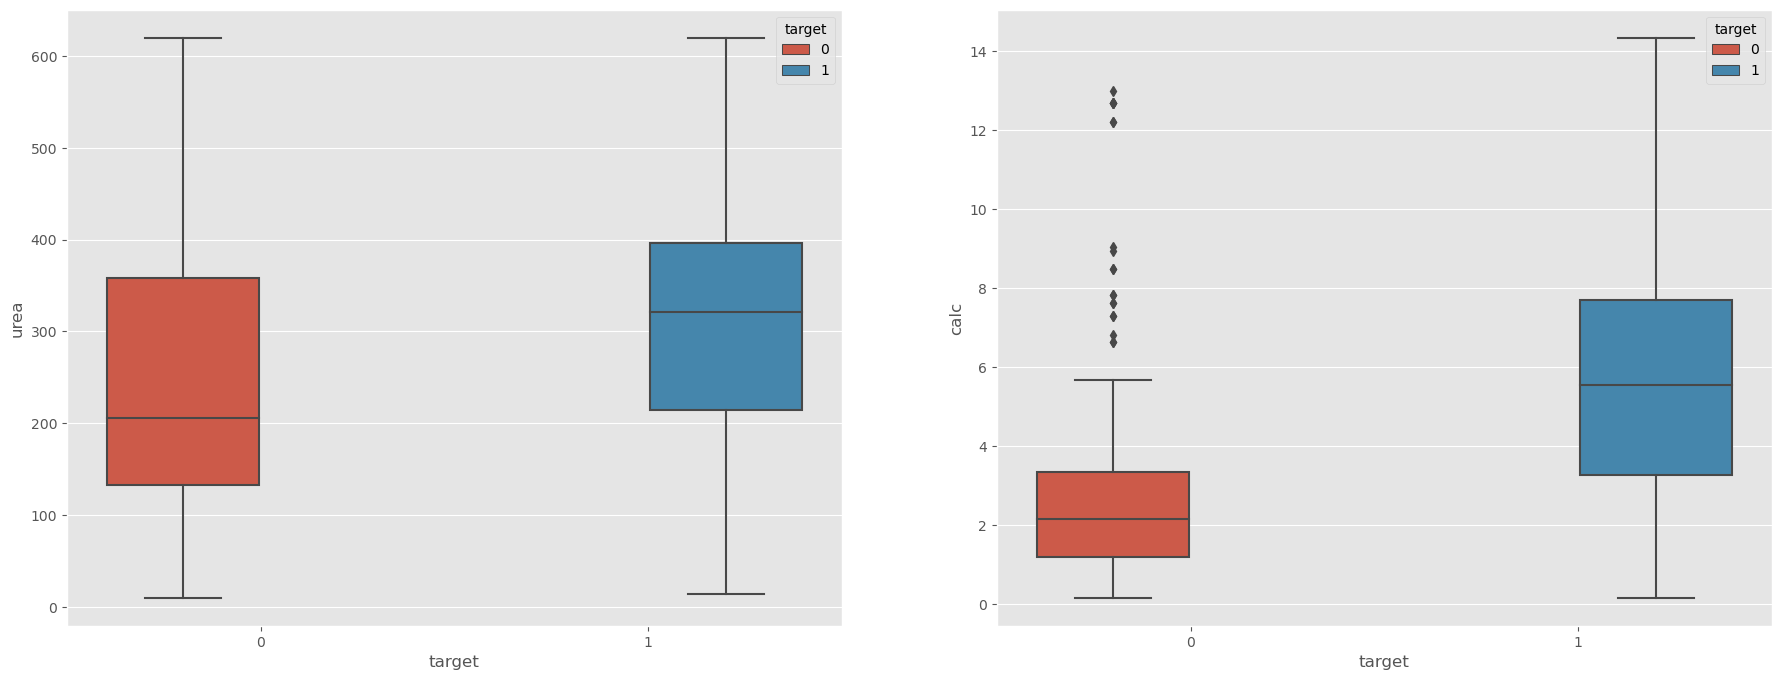

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'target', y = 'urea', hue = 'target', data = train)
sns.boxplot(ax = axes[1], x = 'target', y = 'calc', hue = 'target', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above boxplots, we see the median of target=1 of urea and calc is larger than target=0. </div>

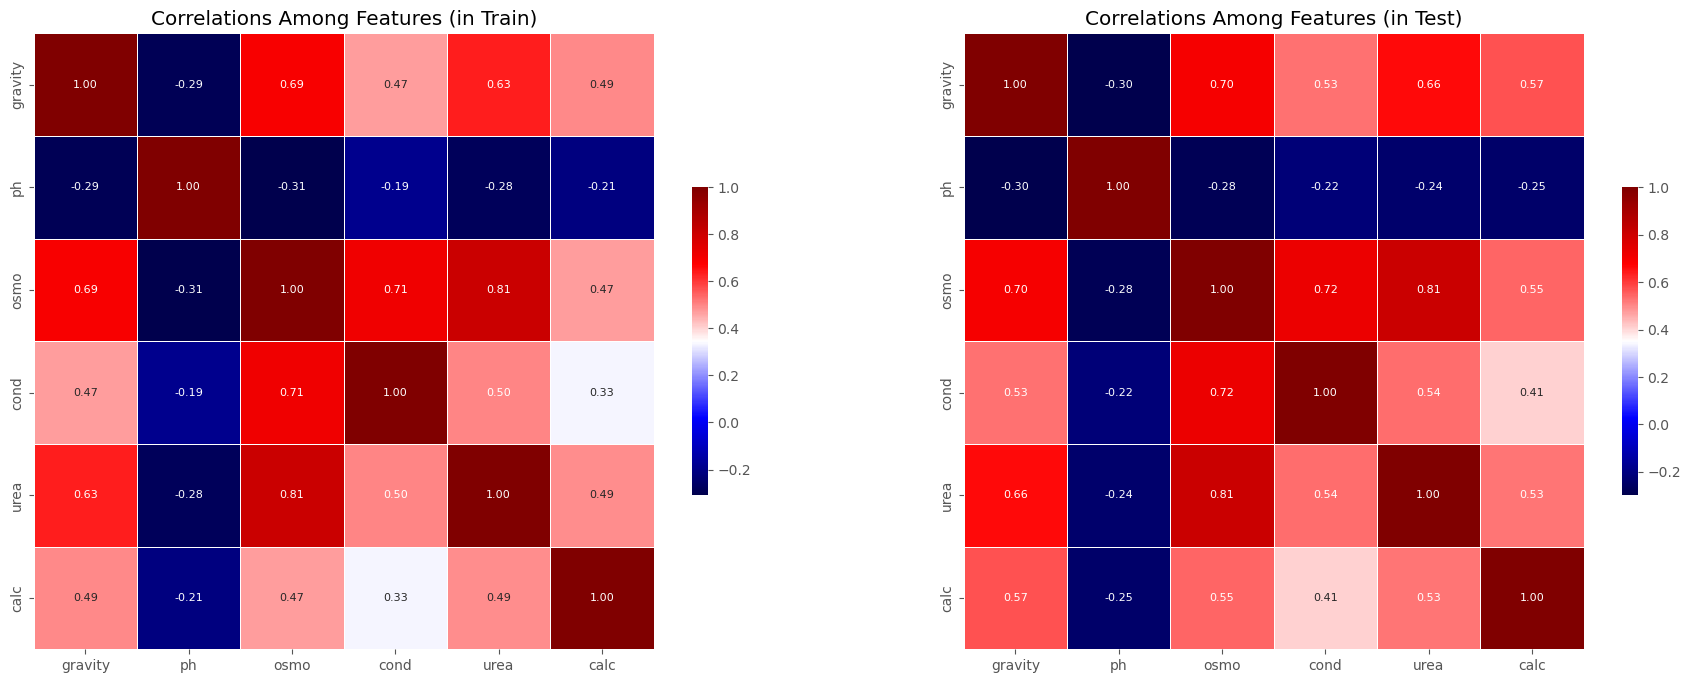

In [13]:
## Explore the correlation between all numerical features
corr_mat_train = train.drop(columns = ['id', 'target'], axis = 1).corr()
corr_mat_test = test.drop(columns = ['id'], axis = 1).corr()

## Keep only correlation higher than a threshold
threshold = 0.1
corr_threshold_train = corr_mat_train[(corr_mat_train > threshold) | (corr_mat_train < -threshold)]
corr_threshold_test = corr_mat_test[(corr_mat_test > threshold) | (corr_mat_test < -threshold)]

fig, axes = plt.subplots(1, 2, figsize = (22, 8))
sns.heatmap(corr_threshold_train, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Correlations Among Features (in Train)')
sns.heatmap(corr_threshold_test, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Features (in Test)');

> <div class="alert alert-block alert-info">
<b>💡</b> From the above heatmaps, we see that the correlation among the features are almost the same in the train and test datasets.
</div>

We next proceed to compare the distribution of the features in the train and test datasets.

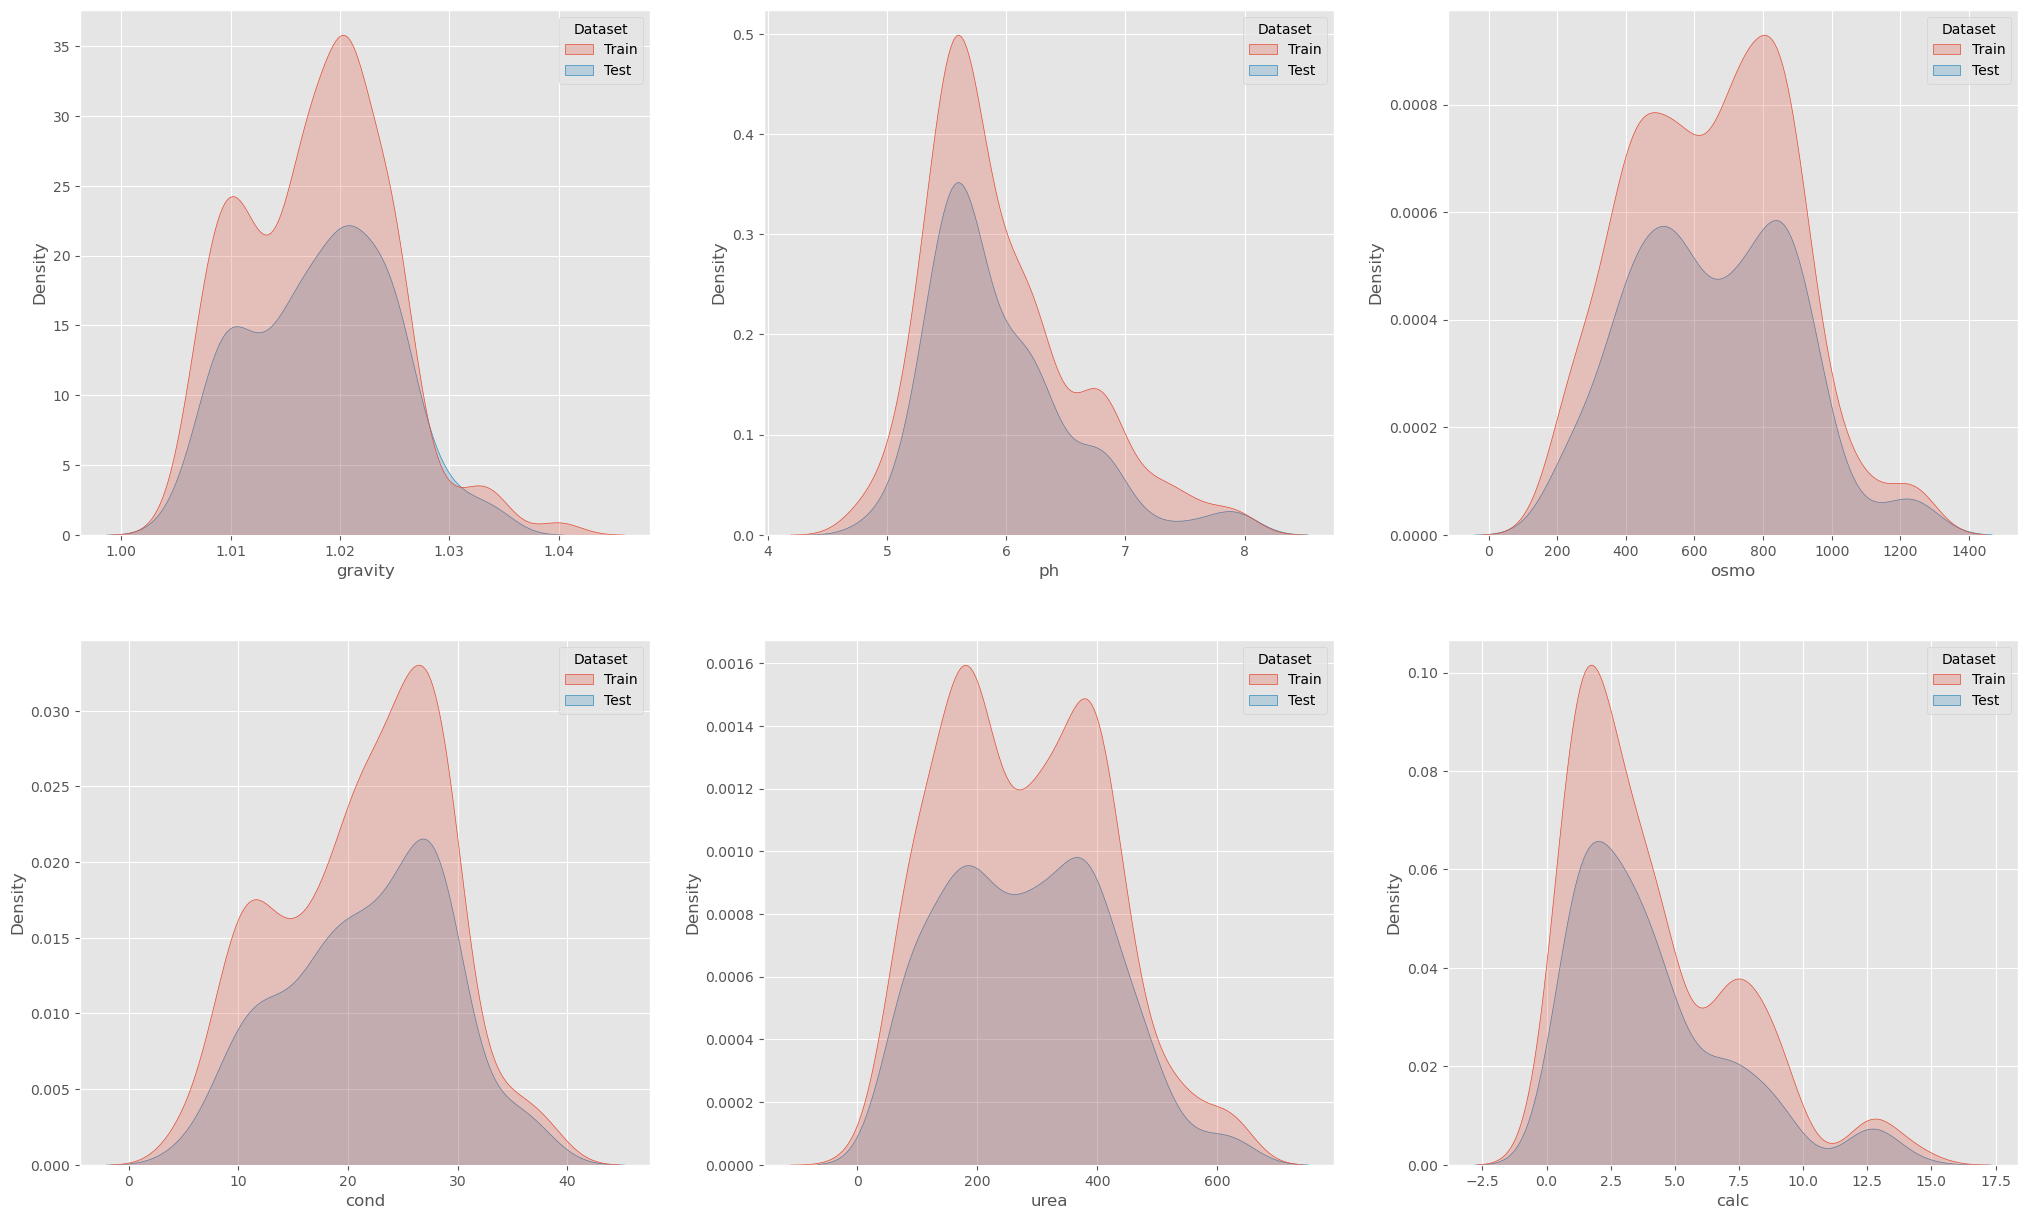

In [14]:
train_vis = train.drop(columns = ['id', 'target'], axis = 1).reset_index(drop = True).copy()
test_vis = test.drop(columns = ['id'], axis = 1).reset_index(drop = True).copy()

train_vis['Dataset'] = 'Train'
test_vis['Dataset'] = 'Test'
data_tot = pd.concat([train_vis, test_vis], axis = 0).reset_index(drop = True)

fig, axes = plt.subplots(2, 3, figsize = (25, 15))

sns.kdeplot(ax = axes[0, 0], x = 'gravity', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'ph', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'osmo', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'cond', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'urea', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'calc', hue = 'Dataset', data = data_tot, fill = True);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above density plots, we see that the distributions of the features are very similar in the train and test datasets.
</div>

We next proceed to check for duplicates.

In [15]:
print('There are ', train.shape[0], ' observations in the train datset')
print('There are ', train.drop(columns = ['id', 'target'], axis = 1).drop_duplicates().shape[0], ' unique observations in the train datset')

There are  414  observations in the train datset
There are  414  unique observations in the train datset


In [16]:
print('There are ', test.shape[0], ' observations in the test datset')
print('There are ', test.drop(columns = ['id'], axis = 1).drop_duplicates().shape[0], ' unique observations in the test datset')

There are  276  observations in the test datset
There are  276  unique observations in the test datset


In [17]:
to_consider = train.drop(columns = ['id', 'target'], axis = 1).columns.tolist()

train_dup = train.drop(columns = ['id', 'target'], axis = 1).drop_duplicates()
test_dup = test.drop(columns = ['id'], axis = 1).drop_duplicates()
duplicates = pd.merge(train_dup, test_dup, on = to_consider)

print('There are ', duplicates.shape[0], ' rows that appear in the train and test dataset.\n')

There are  0  rows that appear in the train and test dataset.



We next proceed to explore the relationship of the features with the highest correlations.

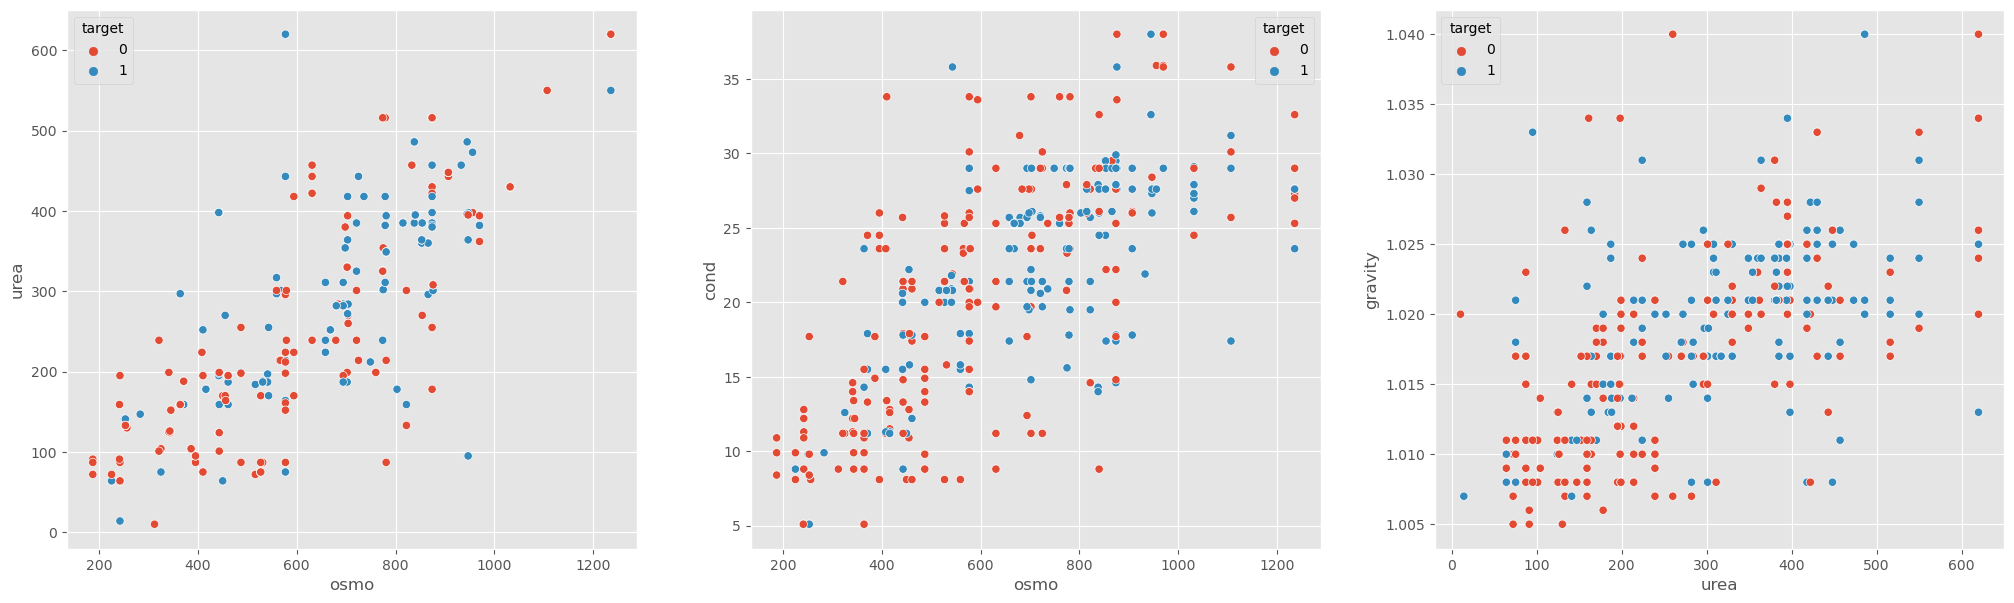

In [18]:
fig, axes = plt.subplots(1, 3, figsize = (25, 7))

sns.scatterplot(ax = axes[0], data = train, x = 'osmo', y = 'urea', hue = 'target')
sns.scatterplot(ax = axes[1], data = train, x = 'osmo', y = 'cond', hue = 'target')
sns.scatterplot(ax = axes[2], data = train, x = 'urea', y = 'gravity', hue = 'target');

 > <div class="alert alert-block alert-info">
<b>💡</b> From the above scatter-plots, we see that there is not a clear pattern.
</div>


<a id="6"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

In this section, we first start by defining the evaluation metric. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. 


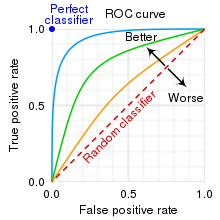

<a id="6.1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Logistic Regression</h1>

In [19]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):
        
    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building logistic model
    model = LogisticRegression(penalty = 'l2',
                               C = 0.01, 
                               max_iter = 10000).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, 'roc-auc-score is', score)
        
cv_scores.append(np.mean(roc_auc_scores))
logit_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the Logistic Regression model over 10-folds is:', logit_cv_score)

Fold 0 roc-auc-score is 0.6910755148741419
Fold 1 roc-auc-score is 0.7391304347826088
Fold 2 roc-auc-score is 0.7620137299771168
Fold 3 roc-auc-score is 0.8375286041189931
Fold 4 roc-auc-score is 0.8454106280193237
Fold 5 roc-auc-score is 0.785024154589372
Fold 6 roc-auc-score is 0.7801932367149758
Fold 7 roc-auc-score is 0.8067632850241546
Fold 8 roc-auc-score is 0.7342995169082125
Fold 9 roc-auc-score is 0.8236714975845411
The oof average roc-auc-score of the Logistic Regression model over 10-folds is: 0.780511060259344


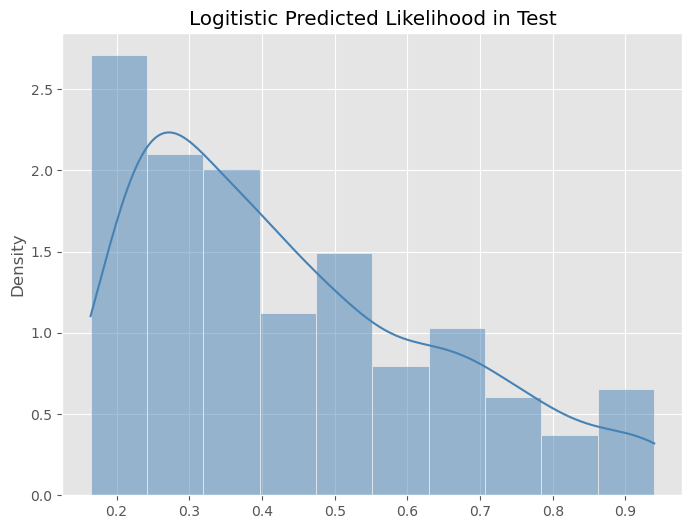

In [20]:
logit_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = logit_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'Logitistic Predicted Likelihood in Test');

<a id="6.2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Random Forest</h1>

In [21]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building RF model
    model = RandomForestClassifier(n_estimators = 500, 
                                   max_depth = 4,
                                   min_samples_split = 15,
                                   min_samples_leaf = 5).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, 'roc-auc-score is', score)
        
cv_scores.append(np.mean(roc_auc_scores))
RF_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the Random Forest model over 10-folds is:', RF_cv_score)

Fold 0 roc-auc-score is 0.7299771167048056
Fold 1 roc-auc-score is 0.6864988558352403
Fold 2 roc-auc-score is 0.7871853546910755
Fold 3 roc-auc-score is 0.8237986270022883
Fold 4 roc-auc-score is 0.8454106280193237
Fold 5 roc-auc-score is 0.8140096618357487
Fold 6 roc-auc-score is 0.8285024154589372
Fold 7 roc-auc-score is 0.8429951690821256
Fold 8 roc-auc-score is 0.785024154589372
Fold 9 roc-auc-score is 0.8526570048309179
The oof average roc-auc-score of the Random Forest model over 10-folds is: 0.7996058988049835


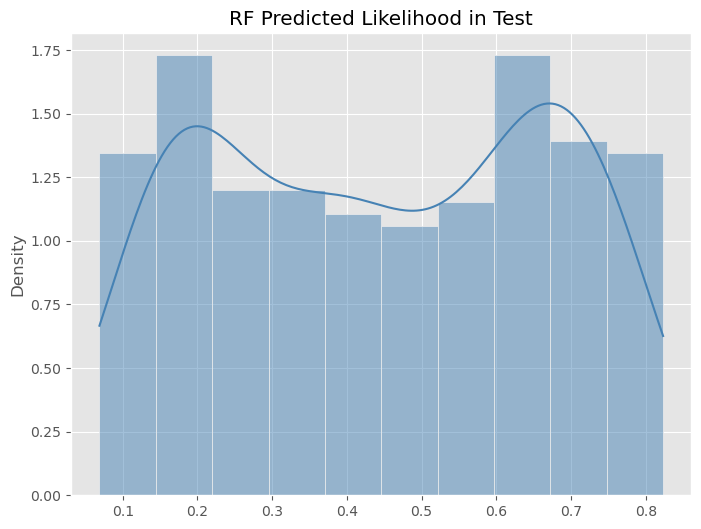

In [22]:
RF_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = RF_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'RF Predicted Likelihood in Test');

<a id="6.3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Extra Trees</h1>

In [23]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building ExtraTrees model
    model = ExtraTreesClassifier(n_estimators = 500, 
                                 max_depth = 4,
                                 min_samples_split = 15,
                                 min_samples_leaf = 5).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, 'roc-auc-score is', score)
        
cv_scores.append(np.mean(roc_auc_scores))
extra_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the Extra Trees model over 10-folds is:', extra_cv_score)

Fold 0 roc-auc-score is 0.7093821510297482
Fold 1 roc-auc-score is 0.6910755148741419
Fold 2 roc-auc-score is 0.7620137299771167
Fold 3 roc-auc-score is 0.8100686498855836
Fold 4 roc-auc-score is 0.855072463768116
Fold 5 roc-auc-score is 0.7826086956521738
Fold 6 roc-auc-score is 0.8285024154589372
Fold 7 roc-auc-score is 0.8043478260869565
Fold 8 roc-auc-score is 0.7536231884057971
Fold 9 roc-auc-score is 0.8333333333333333
The oof average roc-auc-score of the Extra Trees model over 10-folds is: 0.7830027968471904


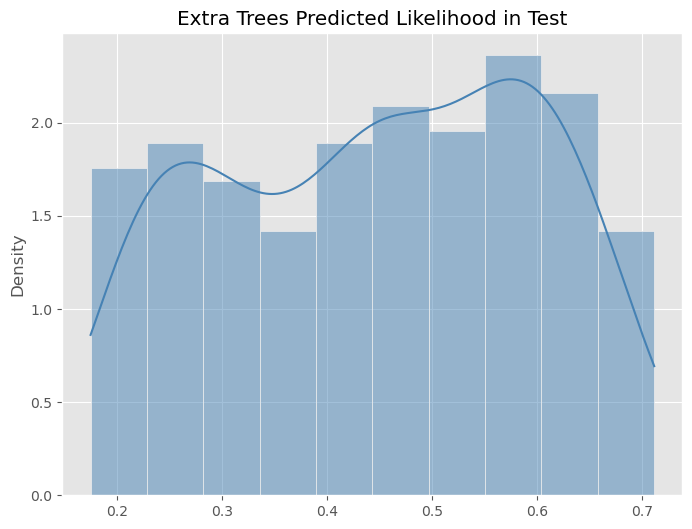

In [24]:
extra_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = extra_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'Extra Trees Predicted Likelihood in Test');

<a id="6.4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">GradientBoosting</h1>

In [25]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building GradientBoosting model
    model = GradientBoostingClassifier(n_estimators = 500, 
                                       learning_rate = 0.01,
                                       max_depth = 4,
                                       min_samples_split = 15,
                                       min_samples_leaf = 5).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, 'roc-auc-score is', score)
        
cv_scores.append(np.mean(roc_auc_scores))
gradient_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the Gradient Boosting model over 10-folds is:', gradient_cv_score)

Fold 0 roc-auc-score is 0.7231121281464531
Fold 1 roc-auc-score is 0.7459954233409611
Fold 2 roc-auc-score is 0.7643020594965675
Fold 3 roc-auc-score is 0.8100686498855836
Fold 4 roc-auc-score is 0.8043478260869564
Fold 5 roc-auc-score is 0.8405797101449275
Fold 6 roc-auc-score is 0.8454106280193237
Fold 7 roc-auc-score is 0.821256038647343
Fold 8 roc-auc-score is 0.7753623188405797
Fold 9 roc-auc-score is 0.8188405797101449
The oof average roc-auc-score of the Gradient Boosting model over 10-folds is: 0.794927536231884


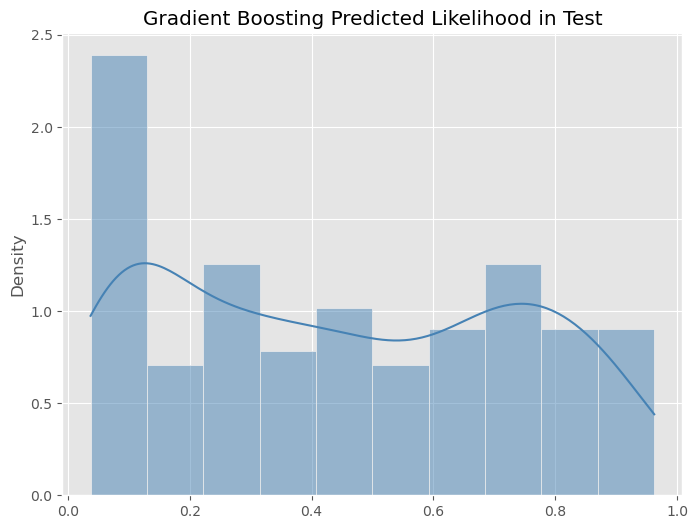

In [26]:
gradient_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = gradient_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'Gradient Boosting Predicted Likelihood in Test');

<a id="6.5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">HistGradientBoosting</h1>

In [27]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building HistGradient model
    model = HistGradientBoostingClassifier(l2_regularization = 0.01,
                                           early_stopping = False,
                                           learning_rate = 0.01,
                                           max_iter = 500,
                                           max_depth = 3,
                                           max_bins = 255,
                                           min_samples_leaf = 5,
                                           max_leaf_nodes = 5).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, 'roc-auc-score is', score)
        
cv_scores.append(np.mean(roc_auc_scores))
hist_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the HistGradient model over 10-folds is:', hist_cv_score)

Fold 0 roc-auc-score is 0.7048054919908466
Fold 1 roc-auc-score is 0.7322654462242563
Fold 2 roc-auc-score is 0.7414187643020594
Fold 3 roc-auc-score is 0.8192219679633866
Fold 4 roc-auc-score is 0.8043478260869565
Fold 5 roc-auc-score is 0.8091787439613526
Fold 6 roc-auc-score is 0.8091787439613527
Fold 7 roc-auc-score is 0.8429951690821256
Fold 8 roc-auc-score is 0.78743961352657
Fold 9 roc-auc-score is 0.8381642512077294
The oof average roc-auc-score of the HistGradient model over 10-folds is: 0.7889016018306636


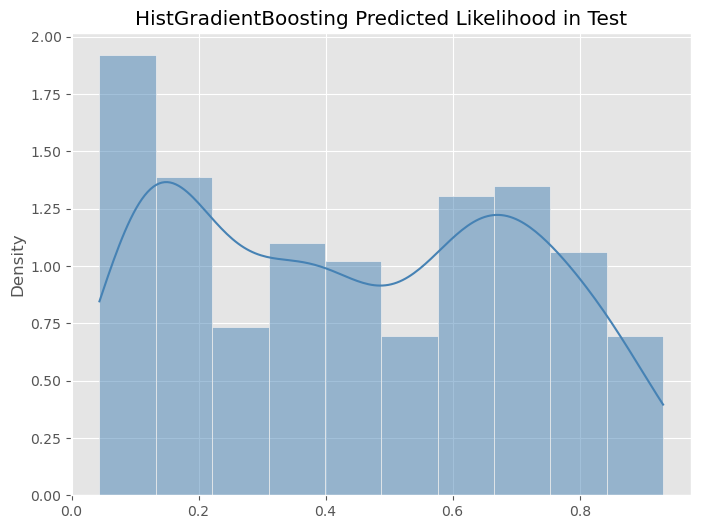

In [28]:
hist_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = hist_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'HistGradientBoosting Predicted Likelihood in Test');

<a id="6.6"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">LightGBM</h1>

In [29]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building LightGBM model
    model = LGBMClassifier(n_estimators = 500,
                           max_depth = 4,
                           learning_rate = 0.01,
                           num_leaves = 20,
                           reg_alpha = 3,
                           reg_lambda = 3,
                           subsample = 0.7,
                           colsample_bytree = 0.7).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, 'roc-auc-score is', score)
        
cv_scores.append(np.mean(roc_auc_scores))
lgb_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the LightGBM model over 10-folds is:', lgb_cv_score)

Fold 0 roc-auc-score is 0.7048054919908467
Fold 1 roc-auc-score is 0.7322654462242563
Fold 2 roc-auc-score is 0.7551487414187643
Fold 3 roc-auc-score is 0.816933638443936
Fold 4 roc-auc-score is 0.7874396135265701
Fold 5 roc-auc-score is 0.8164251207729469
Fold 6 roc-auc-score is 0.8526570048309179
Fold 7 roc-auc-score is 0.8623188405797102
Fold 8 roc-auc-score is 0.7922705314009661
Fold 9 roc-auc-score is 0.8442028985507246
The oof average roc-auc-score of the LightGBM model over 10-folds is: 0.7964467327739639


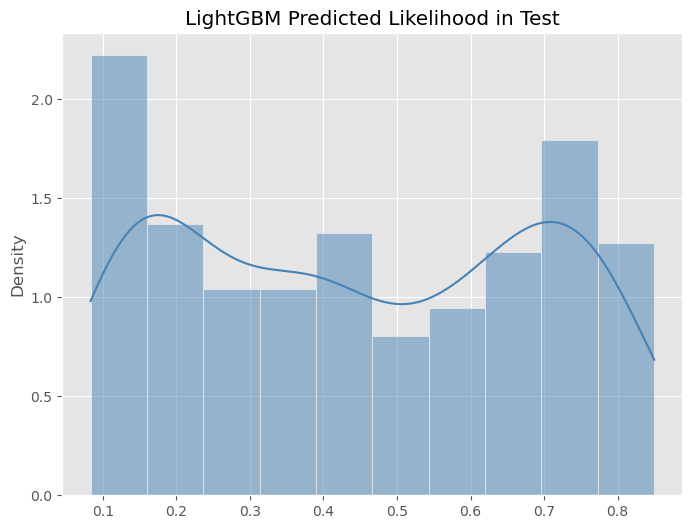

In [30]:
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = lgb_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'LightGBM Predicted Likelihood in Test');

<a id="6.7"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">XGBoost</h1>

In [31]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building XGBoost model
    model = XGBClassifier(tree_method = 'hist',
                          colsample_bytree = 0.7, 
                          gamma = 2, 
                          learning_rate = 0.01, 
                          max_depth = 4, 
                          min_child_weight = 10, 
                          n_estimators = 500, 
                          subsample = 0.7).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, 'roc-auc-score is', score)
        
cv_scores.append(np.mean(roc_auc_scores))
xgb_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the XGBoost model over 10-folds is:', xgb_cv_score)

Fold 0 roc-auc-score is 0.7254004576659039
Fold 1 roc-auc-score is 0.7414187643020594
Fold 2 roc-auc-score is 0.7345537757437072
Fold 3 roc-auc-score is 0.8489702517162471
Fold 4 roc-auc-score is 0.8357487922705313
Fold 5 roc-auc-score is 0.7946859903381642
Fold 6 roc-auc-score is 0.7934782608695652
Fold 7 roc-auc-score is 0.858695652173913
Fold 8 roc-auc-score is 0.7777777777777778
Fold 9 roc-auc-score is 0.8574879227053139
The oof average roc-auc-score of the XGBoost model over 10-folds is: 0.7968217645563183


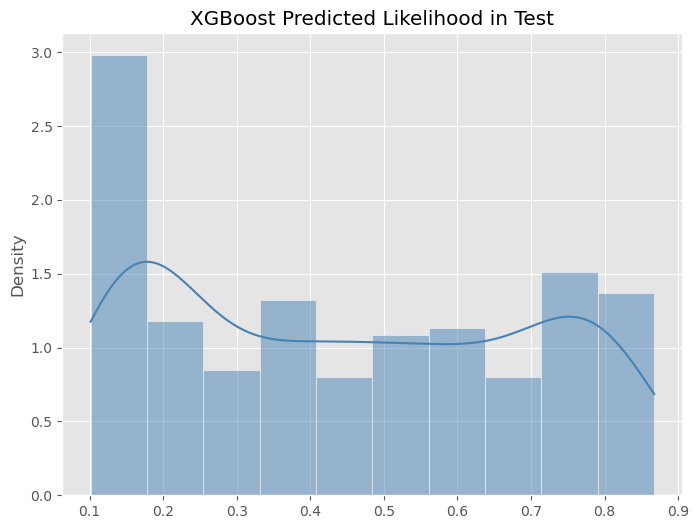

In [32]:
xgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = xgb_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'XGBoost Predicted Likelihood in Test');

<a id="6.8"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">CatBoost</h1>

In [33]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building XGBoost model
    model = CatBoostClassifier(loss_function = 'Logloss',
                               iterations = 500,
                               learning_rate = 0.01,
                               depth = 4,
                               random_strength = 0.5,
                               bagging_temperature = 0.7,
                               border_count = 30,
                               l2_leaf_reg = 5,
                               verbose = False, 
                               task_type = 'CPU').fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, 'roc-auc-score is', score)
        
cv_scores.append(np.mean(roc_auc_scores))
cat_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the CatBoost model over 10-folds is:', cat_cv_score)

Fold 0 roc-auc-score is 0.7208237986270022
Fold 1 roc-auc-score is 0.6933638443935927
Fold 2 roc-auc-score is 0.7528604118993134
Fold 3 roc-auc-score is 0.8489702517162472
Fold 4 roc-auc-score is 0.8285024154589372
Fold 5 roc-auc-score is 0.8067632850241546
Fold 6 roc-auc-score is 0.8526570048309179
Fold 7 roc-auc-score is 0.8236714975845411
Fold 8 roc-auc-score is 0.7946859903381642
Fold 9 roc-auc-score is 0.8454106280193238
The oof average roc-auc-score of the CatBoost model over 10-folds is: 0.7967709127892195


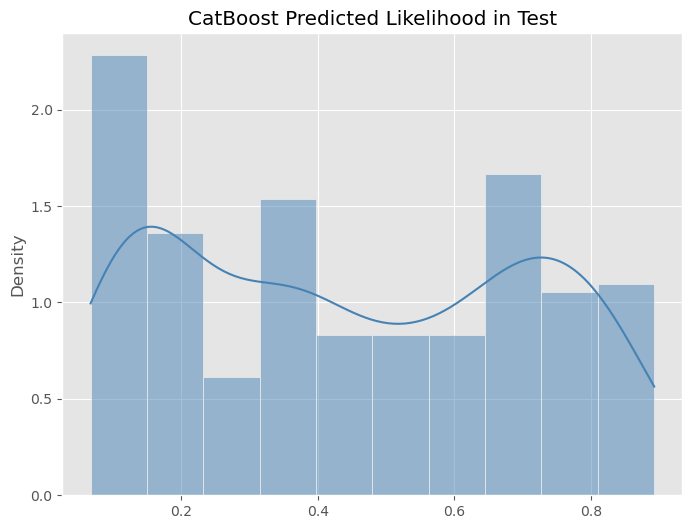

In [34]:
cat_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = cat_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'CatBoost Predicted Likelihood in Test');

<a id="6.9"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Model Comparison</h1>

The below table summarizes the initial baseline modeling results. Notice that these results are based on using raw data without any transformation.

In [35]:
models_perf = pd.DataFrame({'Model': ['Logistic', 'RF', 'ExtraTrees', 'GradientBoosting', 'HistGradient', 'LightGBM', 'XGBoost', 'CatBoost'], 
                            'CV-Score': [logit_cv_score, RF_cv_score, extra_cv_score, gradient_cv_score, hist_cv_score, 
                                         lgb_cv_score, xgb_cv_score, cat_cv_score]})
models_perf

,Model,CV-Score
0,Logistic,0.780511
1,RF,0.799606
2,ExtraTrees,0.783003
3,GradientBoosting,0.794928
4,HistGradient,0.788902
5,LightGBM,0.796447
6,XGBoost,0.796822
7,CatBoost,0.796771


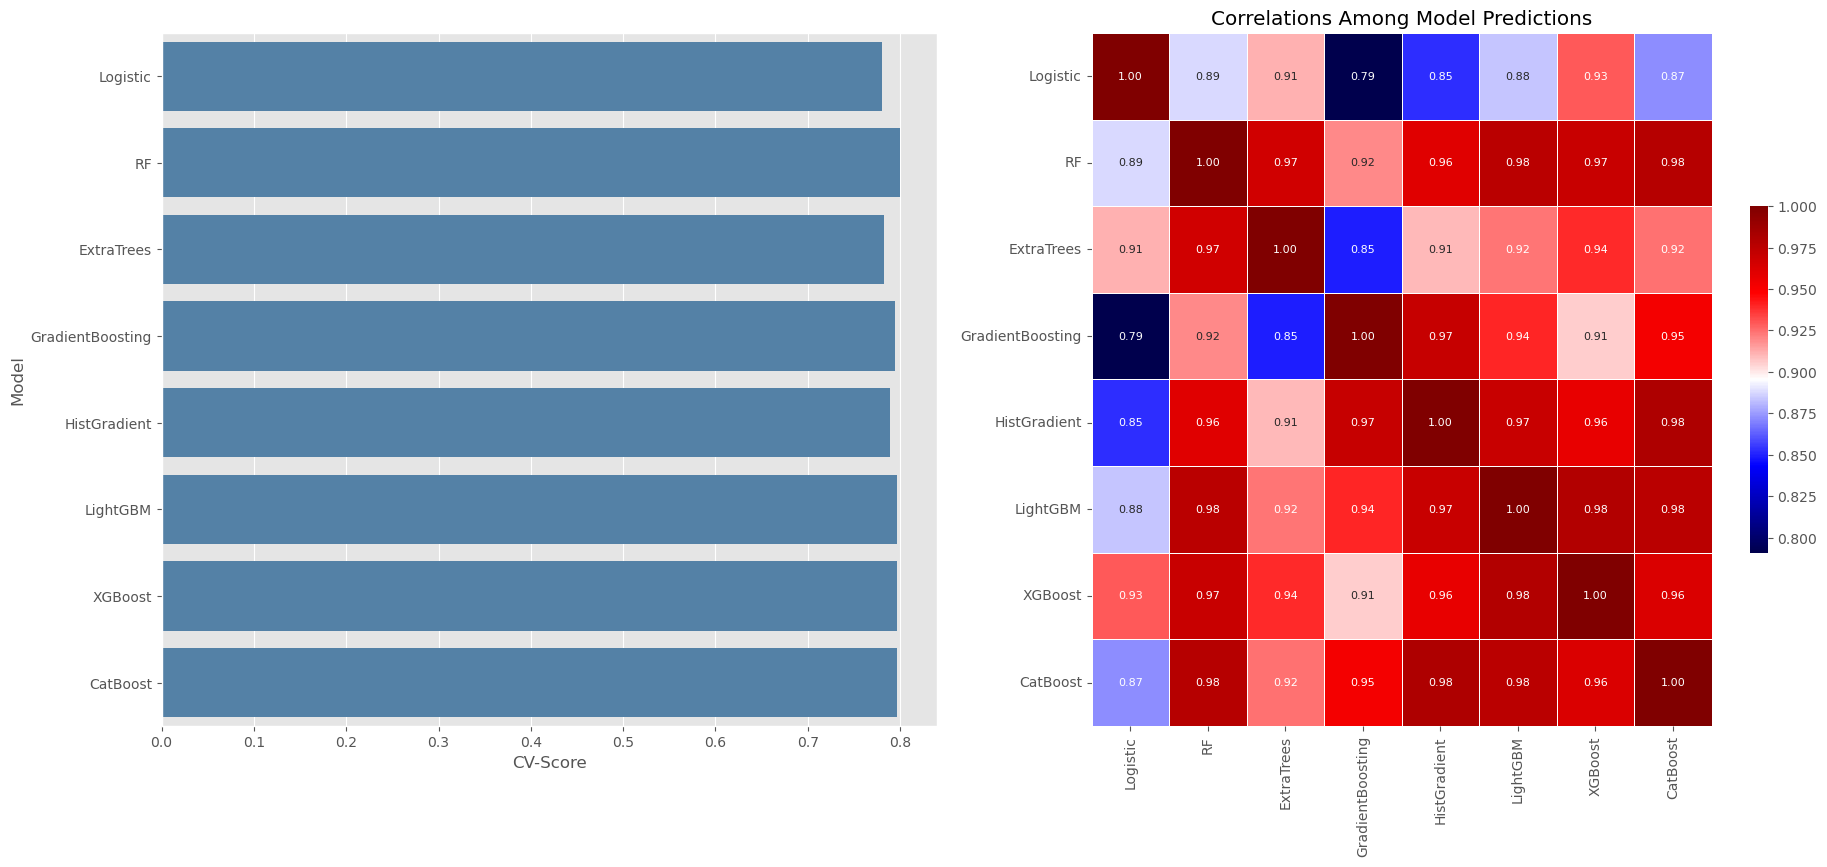

In [36]:
md_preds = pd.DataFrame({'Logistic': logit_preds_test,
                         'RF': RF_preds_test,
                         'ExtraTrees': extra_preds_test,
                         'GradientBoosting': gradient_preds_test,
                         'HistGradient': hist_preds_test,
                         'LightGBM': lgb_preds_test, 
                         'XGBoost': xgb_preds_test,
                         'CatBoost': cat_preds_test})
corr_mat_pred = md_preds.corr()

fig, axes = plt.subplots(1, 2, figsize = (22, 9))

sns.barplot(ax = axes[0], data = models_perf, x = 'CV-Score', y = 'Model', color = 'steelblue')
sns.heatmap(corr_mat_pred, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Model Predictions');

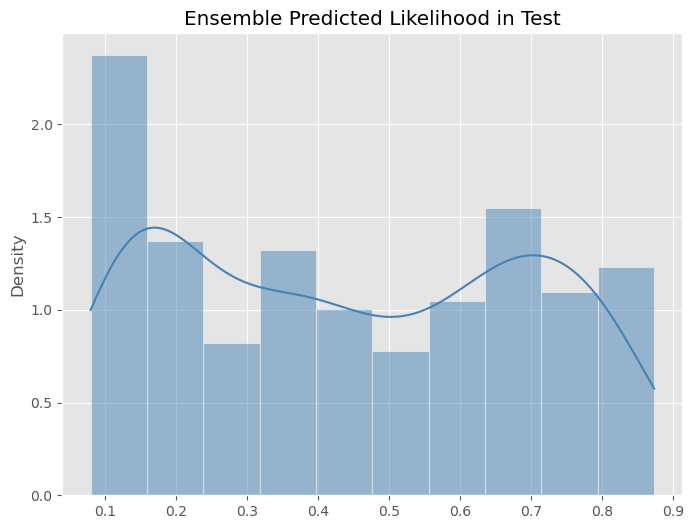

In [37]:
ens_preds_test = (RF_preds_test + gradient_preds_test + lgb_preds_test + xgb_preds_test + cat_preds_test) / 5

plt.figure(figsize = (8, 6))
sns.histplot(data = ens_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'Ensemble Predicted Likelihood in Test');

In [38]:
submission['target'] = ens_preds_test
submission.to_csv('ensemble_baseline_submission.csv', index = False)